In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 805.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 139.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.2/225.2 kB 19.9 MB/s eta 0:00:00


# EMBARCATECH

RESIDÊNCIA TECNOLÓGICA EM SOFTWARE EMBARCADO - PROFESSOR: RICARDO PRATES

DATA: 13/01/2025 - SÍNCRONA

AULA - PRÁTICA COM REDE NEURAL CONVOLUCIONAL - EXEMPLO 01

OBJETIVO: CNN PARA APLICAÇÕES DE TINYML

DATASET: MNIST - https://yann.lecun.org/exdb/mnist/

In [2]:
# ============================================================
# 0) Imports básicos
# ============================================================
# TensorFlow: framework de ML que vamos usar para:
#   - carregar o dataset MNIST
#   - definir e treinar a CNN
#   - converter o modelo para TFLite (INT8) para embarcar no Pico W
import tensorflow as tf

# NumPy: biblioteca para manipular arrays e fazer conversões/reshape
import numpy as np

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [3]:
# ------------------------------------------------------------
# 1) carregar dataset MNIST
# ------------------------------------------------------------
# MNIST: imagens 28x28 (tons de cinza) de dígitos manuscritos (0 a 9).
# Retorna:
#   x_train: (60000, 28, 28) pixels uint8 (0..255)
#   y_train: (60000,) rótulos 0..9
#   x_test : (10000, 28, 28)
#   y_test : (10000,)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalização:
# - Modelos de rede neural treinam melhor com entradas em float e faixa pequena.
# - Aqui a gente faz: pixel_float = pixel_uint8 / 255.0  => faixa [0.0 .. 1.0]
# - Também adicionamos um canal (.., None) para ficar no formato:
#     [N, 28, 28, 1]
#   porque Conv2D espera 4D: batch, altura, largura, canais.
x_train = (x_train.astype(np.float32) / 255.0)[..., None]
x_test  = (x_test.astype(np.float32) / 255.0)[..., None]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Formato: (60000, 28, 28, 1) (60000,)


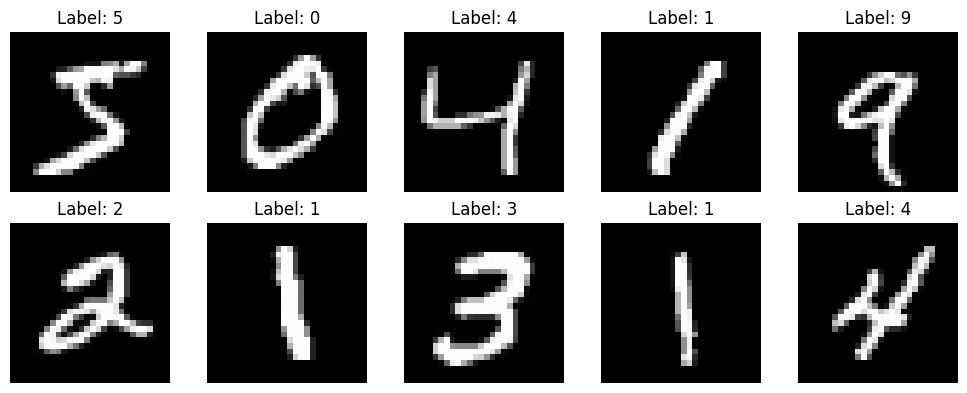

In [4]:
# ------------------------------------------------------------
# 1.1) Apresentar exemplos de imagens
# ------------------------------------------------------------
import matplotlib.pyplot as plt

print("Formato:", x_train.shape, y_train.shape)

# Mostrar 10 imagens iniciais do dataset (apenas para inspeção visual)
plt.figure(figsize=(10,4))
for i in range(10):
    # 2 linhas x 5 colunas
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# ------------------------------------------------------------
# 2) CNN leve e customizada para TinyML
# ------------------------------------------------------------
# CNN mínima (downsample por stride, sem MaxPool)
# A ideia aqui é manter o modelo pequeno em:
#  - número de parâmetros (Flash)
#  - custo computacional (tempo)
#  - memória intermediária (tensor arena no TFLM)
#
# Estratégia usada:
# - Conv2D com stride=2 para reduzir a resolução (downsample) sem usar MaxPool
# - GlobalAveragePooling2D reduz bastante parâmetros vs Flatten + Dense grande
# - Dense final com 10 saídas (classes 0..9)
#
# Observação importante:
# - GlobalAveragePooling2D geralmente vira a operação MEAN no TFLite/TFLM,
#   então no Pico você precisará do resolver.AddMean()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    # Camada 1: 8 filtros 3x3
    # strides=2 reduz 28x28 para ~14x14.
    tf.keras.layers.Conv2D(8, 3, strides=2, padding="same", activation="relu"),
    # Camada 2: 16 filtros 3x3
    # strides=2 reduz ~14x14 para ~7x7.
    tf.keras.layers.Conv2D(16, 3, strides=2, padding="same", activation="relu"),
    # Faz média espacial de cada mapa de ativação => vira um vetor pequeno
    tf.keras.layers.GlobalAveragePooling2D(),   # Será convertido em MEAN no TFLite/TFLM
    # Camada final: 10 classes
    # Softmax para produzir distribuição (no float).
    # No INT8, o softmax é aproximado e serve principalmente para argmax.
    tf.keras.layers.Dense(10, activation="softmax")
])

In [6]:
# ------------------------------------------------------------
# 2.1) Ajuste de hiperparâmetros para compilação
# ------------------------------------------------------------
# optimizer="adam": bom default para começar
# loss="sparse_categorical_crossentropy":
# porque y_train é rótulo inteiro (0..9) e não one-hot
# metrics=["accuracy"]: para monitorar acurácia durante o treino
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Mostra a arquitetura e número de parâmetros (útil para checar "tamanho")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418 (5.54 KB)

 Trainable params: 1,418 (5.54 KB)

 Non-trainable params: 0 (0.00 B)

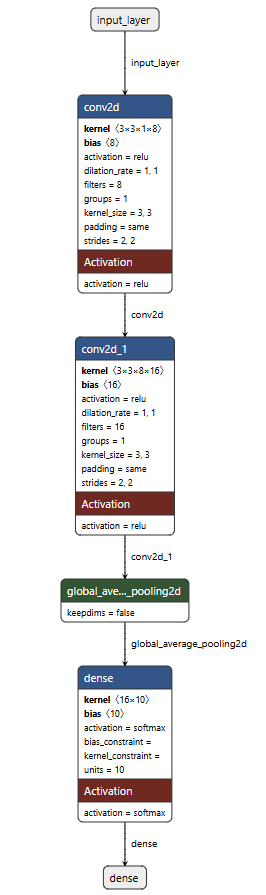

In [7]:
# ------------------------------------------------------------
# 3) Treinar o modelo
# ------------------------------------------------------------
# epochs=40:
# - treina por 40 épocas
# validation_split=0.1:
# - separa 10% do treino para validação (monitorar overfitting)
history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1343 - loss: 2.2544 - val_accuracy: 0.3802 - val_loss: 1.8272
Epoch 2/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3975 - loss: 1.7243 - val_accuracy: 0.4787 - val_loss: 1.4680
Epoch 3/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4698 - loss: 1.4724 - val_accuracy: 0.5360 - val_loss: 1.3424
Epoch 4/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5058 - loss: 1.3789 - val_accuracy: 0.5648 - val_loss: 1.2596
Epoch 5/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5431 - loss: 1.3026 - val_accuracy: 0.5935 - val_loss: 1.1882
Epoch 6/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5774 - loss: 1.2329 - val_accuracy: 0.6187 - val_loss: 1.1316
Epoch 7/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6040 - loss: 1.1834 - val_accuracy: 0.6513 - val_loss: 1.0679
Epoch 8/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6315 - loss: 1.1176 - val_accuracy: 0.

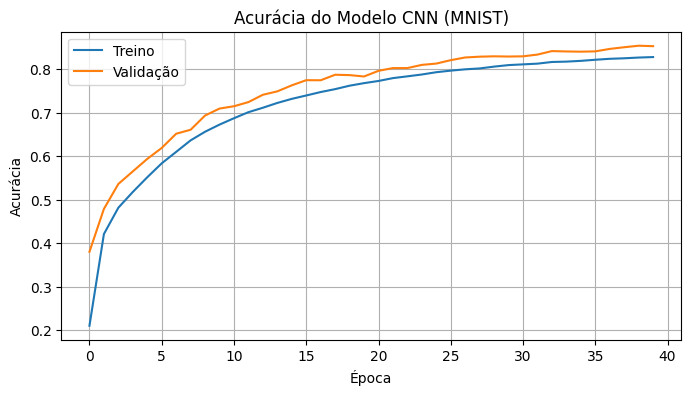

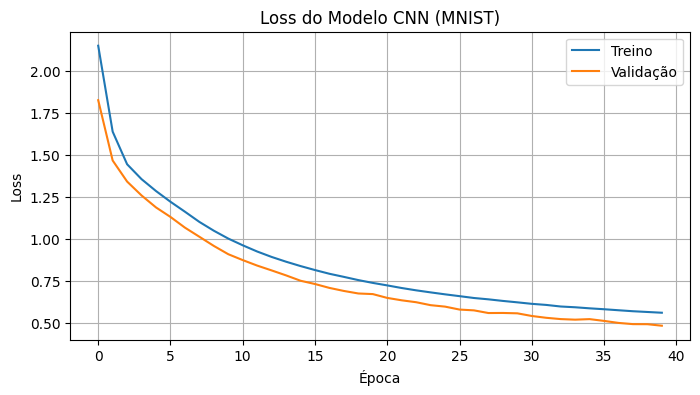

In [8]:
# ------------------------------------------------------------
# 3.1) Avaliação do desempenho de treinamento
# ------------------------------------------------------------
# history.history é um dicionário que contém listas por época:
# - 'accuracy', 'val_accuracy', 'loss', 'val_loss'

# === Acurácia ===
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo CNN (MNIST)')
plt.legend()
plt.grid(True)
plt.show()

# === Loss ===
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss do Modelo CNN (MNIST)')
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


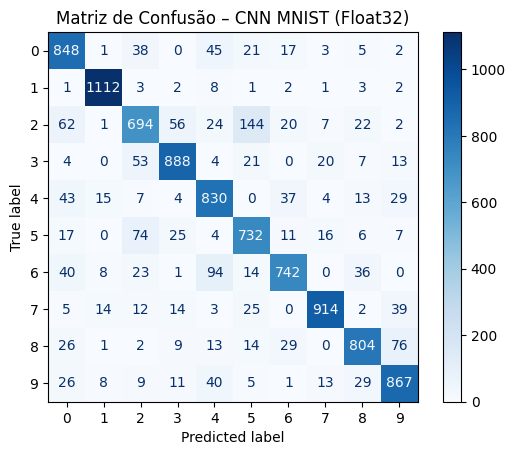

Acurácia final (treino): 82.74%
Acurácia final (validação): 85.25%


In [9]:
# ------------------------------------------------------------
# 3.2) Avaliação do desempenho de classificação - Matrix de Confusão
# ------------------------------------------------------------
# Acurácia sozinha não diz “onde” o modelo erra.
# Matriz de confusão mostra confusões específicas (ex.: 4 confundindo com 9).
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model.predict(x_test) retorna probabilidades (float) [N, 10]
# argmax -> classe prevista (0..9)
y_pred = np.argmax(model.predict(x_test), axis=1)

# Matriz de confusão
# cm[i, j] = quantidade de exemplos da classe verdadeira i preditos como j
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão – CNN MNIST (Float32)")
plt.show()

# Imprimir as acurácias finais de treino
final_train_acc = history.history['accuracy'][-1]
final_val_acc   = history.history['val_accuracy'][-1]
print(f"Acurácia final (treino): {final_train_acc*100:.2f}%")
print(f"Acurácia final (validação): {final_val_acc*100:.2f}%")

In [10]:
# ============================================================
# 4) Salvar o modelo treinado (Keras)
# ============================================================
# Em versões novas do Keras, é obrigatório:
# - extensão .keras (recomendado)
# - ou .h5
model.save("mnist_cnn_float.keras")

In [11]:
# ============================================================
# 4.1) Download do modelo no Colab
# ============================================================
# Baixa o arquivo para sua máquina (para arquivar, comparar, etc.)
from google.colab import files
files.download("mnist_cnn_float.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# ------------------------------------------------------------
# 5) Converter para TFLite INT8 (entrada/saída INT8)
# ------------------------------------------------------------
# O ponto crítico da quantização: representative_dataset
# - Serve para calibrar escalas/zero_point com dados parecidos com o real.
def rep_data_gen():
    # 200 amostras para calibração já costumam funcionar bem no MNIST.
    # IMPORTANTE: deve ter o mesmo pré-processamento do treino.
    for i in range(200):
        yield [x_train[i:i+1]]

# Converte do modelo Keras para TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Ativa otimizações (inclui quantização)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data_gen

# Força que as operações e tensores sejam INT8
# - Isso é o cenário típico para microcontroladores (melhor RAM/Flash e velocidade).
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Gera o modelo final (bytes) - Obs.: não tive êxito na RNN
tflite_int8 = converter.convert()

# Salva em disco
open("mnist_cnn_int8.tflite", "wb").write(tflite_int8)
print("TFLite INT8 size (bytes):", len(tflite_int8))

Saved artifact at '/tmp/tmpiu8pjnzw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134121602895696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134121602896848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134121602895504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134121602893200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134121602897424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134121602894928: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite INT8 size (bytes): 5200


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [13]:
# ------------------------------------------------------------
# 5.1) Converter .tflite em header C (model.h)
# ------------------------------------------------------------
# No Pico W (C/C++), a forma mais simples é embutir o modelo como array de bytes
# dentro do firmware: const unsigned char model[] = { ... };
import binascii

data = open("mnist_cnn_int8.tflite","rb").read()
hexstr = binascii.hexlify(data).decode("ascii")

with open("mnist_cnn_int8_model.h", "w") as f:
    #f.write('#pragma once\n#include <cstdint>\n\n')
    f.write('#pragma once\n#include <stdint.h>\n\n')
    f.write('alignas(16) const unsigned char mnist_cnn_int8_model[] = {\n')
    # Escreve 12 bytes por linha (só para deixar “legível”)
    for i in range(0, len(hexstr), 2*12):
        chunk = hexstr[i:i+2*12]
        bytes_list = [f"0x{chunk[j:j+2]}" for j in range(0, len(chunk), 2)]
        f.write("  " + ", ".join(bytes_list) + ",\n")
    f.write("};\n")
    f.write(f"const unsigned int mnist_cnn_int8_model_len = {len(data)};\n")

print("Wrote mnist_cnn_int8_model.h")

Wrote mnist_cnn_int8_model.h


In [14]:
# ------------------------------------------------------------
# 5.1.1) Imprimir parte do modelo em .h -> fins didáticos
# ------------------------------------------------------------
# Mostra o começo do arquivo para evidenciar:
# - cabeçalho C/C++
# - início do array (bytes do TFLite; costuma começar com 'TFL3' no header)
with open("mnist_cnn_int8_model.h", "r") as f:
    lines = f.readlines()

# Imprimir apenas as primeiras linhas (cabeçalho + início do array)
for i in range(30):
    print(lines[i])

#pragma once

#include <stdint.h>



alignas(16) const unsigned char mnist_cnn_int8_model[] = {

  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,

  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,

  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,

  0x98, 0x00, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00, 0x20, 0x08, 0x00, 0x00,

  0x30, 0x08, 0x00, 0x00, 0xbc, 0x13, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,

  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,

  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,

  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,

  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,

  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,

  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00,

  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70,

  0

In [15]:
# ------------------------------------------------------------
# 5.2) Exportar 1 imagem de teste para rodar no Pico
# ------------------------------------------------------------
# - garantir que o Pico W está recebendo uma entrada válida
# - pode comparar o resultado do Pico W com o Colab
idx = 0  # escolha um índice do x_test
img = (x_test[idx] * 255.0).astype(np.uint8).reshape(28,28)
label = int(y_test[idx])
print("Label:", label)

with open("mnist_sample.h", "w") as f:
    f.write('#pragma once\n#include <cstdint>\n\n')
    f.write(f'const int mnist_sample_label = {label};\n')
    f.write('const uint8_t mnist_sample_28x28[28*28] = {\n')
    flat = img.flatten()
    for i in range(0, len(flat), 16):
        row = ", ".join(str(int(v)) for v in flat[i:i+16])
        f.write("  " + row + ",\n")
    f.write("};\n")

print("Wrote mnist_sample.h")

Label: 7
Wrote mnist_sample.h


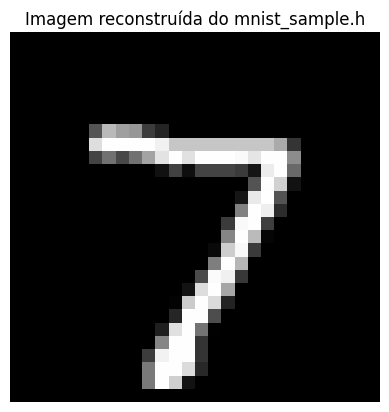

In [16]:
# ------------------------------------------------------------
# 5.2.1) Reconstruir a imagem mnist_sample.h e plotar -> fins didáticos
# ------------------------------------------------------------
# - a imagem virou um vetor de 28x28 = 784 números (0..255)
# - dá para reconstruir exatamente a imagem original
data = []
with open("mnist_sample.h") as f:
    for line in f:
        if ',' in line:
            nums = line.replace(',', ' ').split()
            for n in nums:
                if n.isdigit():
                    data.append(int(n))

img = np.array(data[:28*28]).reshape(28,28)

plt.imshow(img, cmap='gray')
plt.title("Imagem reconstruída do mnist_sample.h")
plt.axis('off')
plt.show()

In [17]:
# ------------------------------------------------------------
# 5.2.2) imprimir a imagem mnist_sample.h como uma matriz com os seus
# valores reais -> Visualização para fins didáticos
# ------------------------------------------------------------
pixels = []

with open("mnist_sample.h") as f:
    for line in f:
        if "," in line:
            parts = line.replace(",", " ").split()
            for p in parts:
                if p.isdigit():
                    pixels.append(int(p))

# Converter para matriz 28x28
img = np.array(pixels[:28*28]).reshape(28,28)

np.set_printoptions(linewidth=120)

print("Matriz 28x28 de valores de pixel (0–255):\n")
print(img)

Matriz 28x28 de valores de pixel (0–255):

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254

In [18]:
# ============================================================
# 5.3) Baixar os headers para usar no Pico W
# ============================================================
files.download("mnist_cnn_int8_model.h")
files.download("mnist_sample.h")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# ------------------------------------------------------------
# 6) Teste do modelo . h -> Carregar o modelo direto do .h (C → Python)
# ------------------------------------------------------------
# Objetivo:
# - Carregar o header C de volta para bytes
# - Instanciar Interpreter usando model_content
# - Alimentar a imagem do mnist_sample.h
# Isso prova que o que vai para o Pico W está coerente.
import re

# --- Extrair bytes do header C ---
hex_bytes = []

with open("mnist_cnn_int8_model.h") as f:
    for line in f:
        if "0x" in line:
            parts = line.strip().split(",")
            for p in parts:
                p = p.strip()
                if p.startswith("0x"):
                    hex_bytes.append(int(p, 16))

tflite_model = bytes(hex_bytes)

print("TFLite bytes:", len(tflite_model))

TFLite bytes: 5200


In [20]:
# ------------------------------------------------------------
# 6.1) Criar o Interpretador TFLite com esse modelo
# ------------------------------------------------------------
# model_content permite passar o modelo sem depender do arquivo .tflite em disco
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input:", input_details)
print("Output:", output_details)

Input: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [{'name': 'StatefulPartitionedCall_1:0', 'index': 12, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [21]:
# ============================================================
# 6.2) Ler a imagem do mnist_sample.h (a mesma que o Pico vai usar)
# ============================================================
# Ler pixels do header C
pixels = []
label = None

with open("mnist_sample.h") as f:
    for line in f:
        if "mnist_sample_label" in line:
            label = int(line.split("=")[1].replace(";", ""))
        if "," in line:
            for p in line.replace(",", " ").split():
                if p.isdigit():
                    pixels.append(int(p))

pixels = np.array(pixels[:28*28], dtype=np.uint8).reshape(28,28)

print("Label real:", label)

Label real: 7


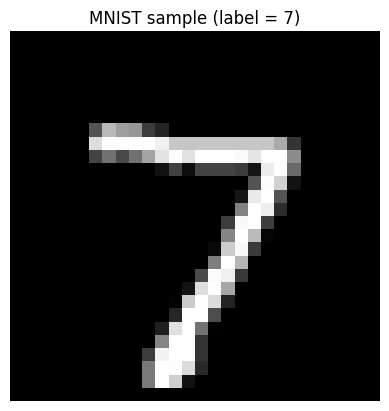

In [22]:
# ------------------------------------------------------------
# 6.2.1) Visualizar a imagem (sanity check)
# ------------------------------------------------------------
plt.imshow(pixels, cmap="gray")
plt.title(f"MNIST sample (label = {label})")
plt.axis("off")
plt.show()

In [23]:
# ============================================================
# 6.2.2) Pré-processar + quantizar igual ao Pico W
# ============================================================
# Importante:
# - No treino: x = pixel/255.0 (float) em [0..1]
# - No TFLite INT8: precisamos mapear esse float para int8 usando (scale, zp)

# Converter para float igual ao treino
x = pixels.astype(np.float32) / 255.0
x = np.expand_dims(x, axis=(0,3))   # [1,28,28,1]

# Parâmetros de quantização do input
in_scale, in_zp = input_details[0]["quantization"]

# Quantização:
#   q = round(x/scale + zero_point)
# E o dtype final precisa ser int8 porque configuramos inference_input_type = int8
x_q = np.round(x / in_scale + in_zp).astype(np.int8)

In [24]:
# ------------------------------------------------------------
# 6.3) Rodar inferência
# ------------------------------------------------------------
interpreter.set_tensor(input_details[0]["index"], x_q)
interpreter.invoke()

# Saída do modelo (vetor de 10 logits/probabilidades quantizadas)
out = interpreter.get_tensor(output_details[0]["index"])[0]

# Classe final (o que importa no embarcado): maior valor
pred = np.argmax(out)

print("Predição INT8:", pred)

Predição INT8: 7


In [25]:
# ------------------------------------------------------------
# 6.3.1) Dequantizar para ver “probabilidades”
# ------------------------------------------------------------
# Atenção didática:
# - Em INT8, o softmax quantizado tem baixa resolução.
# - Esses valores dequantizados podem parecer “estranhos” (muitos zeros etc.).
# - Para decisão, use argmax(out) (em int8) e pronto.
out_scale, out_zp = output_details[0]["quantization"]

probs = (out - out_zp) * out_scale

for i, p in enumerate(probs):
    print(f"{i}: {p:.4f}")

0: 0.0000
1: 0.0000
2: 0.0000
3: 0.0000
4: 0.0000
5: 0.0000
6: 0.0000
7: -0.0039
8: 0.0000
9: 0.0000


Nota:

Em modelos INT8, o Softmax também é quantizado.
Isso causa colapso de resolução.

Exemplo típico:

output_scale ≈ 1/256 ≈ 0.0039

Logo:

1 passo de INT8 = 0.0039 em float

Então:

valores menores que isso viram zero

valores negativos viram −0.0039

Ou seja:

O Softmax está sendo representado com apenas ~256 níveis possíveis.

Obs.1: Em sistemas embarcados, você usa Softmax INT8 apenas para escolher a classe (argmax), não para analisar confiança.

Obs.2: A classe 7 ficou um “nível” acima das outras no ranking INT8. Mesmo sendo negativo em float, ela foi a maior entre os inteiros.



- Continuação da prática:

🎯 Objetivo: Roteiro para implementar no Raspberry Pi Pico W o código trabalhado -> MNIST + CNN INT8 + mnist_cnn_int8_model.h + mnist_sample.h. No Pico SDK, trabalhr com o main em C e o mínimo possível em C++ - só o wrapper do TFLM (pico-tflmicro).

1) Saída do Colab (o que precisa estar pronto) - No Colab, gere e baixe para o PC:

* mnist_cnn_int8_model.h ✅ (modelo INT8 em array C)

* mnist_sample.h ✅ (uma imagem MNIST em uint8_t[784] + label)

2) Preparar o ambiente no PC (uma vez) - Instalar/configurar:

* Visual Studio, Pico SDK (inclui pico_sdk_import.cmake)

* Toolchain ARM (arm-none-eabi-gcc)

* CMake + Ninja (ou Make)

* Drivers/USB do Pico W (CDC)

3) Obter o TensorFlow Lite Micro para Pico - Clone ao lado do seu projeto:

* pico-tflmicro (porta oficial do TFLM para Pico/RP2040)

* Clone o repositório: git clone https://github.com/raspberrypi/pico-tflmicro.git

4) Criar a estrutura do projeto do Pico W - Ex: Dentro de cnn_mnist/:

CMakeLists.txt

main.c

tflm_wrapper.h
  
tflm_wrapper.cpp
  
mnist_cnn_int8_model.h
  
mnist_sample.h

pico_sdk_import.cmake

5) Etregáveis esperados:

* Firmware Pico W rodando TFLM

* Predição correta do mnist_sample.h

* Avaliar 10 imagens diferentes do dataset MNIST

Logs com:

* label real e predito

* (opcional) scores dequantizados


# Amostras para inferência

In [27]:
# Verifica se o x_test está normalizado (0.0 a 1.0) e converte para 0-255 (formato que o React/C esperam)
# OBS: Certifique-se de que suas variáveis de teste se chamam x_test e y_test
if x_test.max() <= 1.0:
    x_test_255 = (x_test * 255).astype(np.uint8)
else:
    x_test_255 = x_test.astype(np.uint8)

print("/* === COPIE O CÓDIGO ABAIXO E SUBSTITUA NO SEU REACT (App.jsx) === */\n")
print("const TEST_DATASET = [")

selected_indices = []

# Loop para pegar exatamente um dígito de cada classe (0 a 9)
for digit in range(10):
    # Encontra o índice da primeira ocorrência do dígito atual no dataset de teste
    idx = np.where(y_test == digit)[0][0]
    selected_indices.append(idx)

    # Achata a imagem 28x28 para um vetor unidimensional de 784 posições
    img_flat = x_test_255[idx].flatten()

    # Formata o array para string
    vector_str = ",".join(map(str, img_flat))

    print(f"  {{")
    print(f"    id: {digit + 1},")
    print(f"    label: {digit},")
    print(f"    description: \"Dígito {digit} (Amostra extraída do MNIST)\",")
    print(f"    vector: [{vector_str}]")
    print(f"  }},")

print("];")
print("\n/* ================================================================ */")

/* === COPIE O CÓDIGO ABAIXO E SUBSTITUA NO SEU REACT (App.jsx) === */

const TEST_DATASET = [
  {
    id: 1,
    label: 0,
    description: "Dígito 0 (Amostra extraída do MNIST)",
    vector: [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,150,253,202,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,251,251,253,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,197,251,251,253,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110,190,251,251,251,253,169,109,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,251,251,251,251,253,251,251,220,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,182,255,253,253,253,253,234,222,253,253,253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,221,253,251,251,251,147,77,62,128,251,251,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,231,251,253,251,220,137,10,0,0,31,230,251,243,113,5,0,0,0,0,0,0,

In [29]:
TFLITE_MODEL_PATH = "mnist_cnn_int8.tflite"

# Inicializa o interpretador TFLite
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

input_scale, input_zero_point = input_details["quantization"]
output_scale, output_zero_point = output_details["quantization"]

print("=== RESULTADOS DA INFERÊNCIA NO COLAB (TFLITE INT8) ===\n")

acertos = 0

for digit, idx in enumerate(selected_indices):
    # 1. Pega a imagem float original (0.0 a 1.0)
    test_image = x_test[idx]
    if test_image.max() > 1.0:
        test_image = test_image / 255.0

    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)

    # Ajusta o shape para (1, 28, 28, 1) se o seu modelo foi treinado assim
    if len(input_details['shape']) == 4:
        test_image = test_image.reshape((1, 28, 28, 1))

    # 2. Quantizar a entrada (mesma matemática que está rodando no microcontrolador)
    if input_scale > 0:
        test_image_quantized = test_image / input_scale + input_zero_point
        test_image_quantized = np.clip(np.round(test_image_quantized), -128, 127).astype(np.int8)
    else:
        test_image_quantized = test_image.astype(np.int8)

    # 3. Invocar o modelo localmente
    interpreter.set_tensor(input_details['index'], test_image_quantized)
    interpreter.invoke()

    # 4. Obter a saída (Int8) e processar
    output_data = interpreter.get_tensor(output_details['index'])[0]

    predicted_label = np.argmax(output_data)

    # Cálculo da confiança usando os parâmetros de desquantização
    raw_score = output_data[predicted_label]
    confidence = (raw_score - output_zero_point) * output_scale

    if predicted_label == digit:
        acertos += 1
        status = "✅ Acertou"
    else:
        status = "❌ Errou "

    print(f"Amostra Real: {digit} | Predição: {predicted_label} | Confiança: {confidence*100:05.2f}% | {status}")

print(f"\nResumo: Acertou {acertos}/10")

=== RESULTADOS DA INFERÊNCIA NO COLAB (TFLITE INT8) ===

Amostra Real: 0 | Predição: 0 | Confiança: -49.22% | ✅ Acertou
Amostra Real: 1 | Predição: 1 | Confiança: -0.78% | ✅ Acertou
Amostra Real: 2 | Predição: 2 | Confiança: -41.41% | ✅ Acertou
Amostra Real: 3 | Predição: 2 | Confiança: 39.06% | ❌ Errou 
Amostra Real: 4 | Predição: 4 | Confiança: -3.52% | ✅ Acertou
Amostra Real: 5 | Predição: 5 | Confiança: -13.28% | ✅ Acertou
Amostra Real: 6 | Predição: 6 | Confiança: 48.05% | ✅ Acertou
Amostra Real: 7 | Predição: 7 | Confiança: -0.39% | ✅ Acertou
Amostra Real: 8 | Predição: 8 | Confiança: -46.48% | ✅ Acertou
Amostra Real: 9 | Predição: 6 | Confiança: 37.11% | ❌ Errou 

Resumo: Acertou 8/10


/tmp/ipython-input-2773353723.py:48: RuntimeWarning: overflow encountered in scalar subtract
  confidence = (raw_score - output_zero_point) * output_scale
